In [39]:
from IPython import display
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import (
    pyplot as plt,
    ticker,
)
from tqdm.notebook import tqdm
from pprint import pp
import requests
import json
import ast
import librosa
import whisper
import torch
import jiwer
import warnings
warnings.filterwarnings(
    action="ignore",
    message="PySoundFile.*",
    category=FutureWarning,
    module=".*",
)

plt.style.use("minimal.mplstyle")

class COLORMAP:
    F1_red = "#E10600"

audio_files_path = Path() / "data" / "radio_messages/"

- ALEALB01_23_20240229_154846 optics > upshift
- LANNOR01_4_20250419_205244 im an f'ing idiot
- MAXVER01_1_20250413_181201 lado > lando
- LANNOR01_4_20240824_122457 landon > lando
- LANNOR01_4_20250906_163307 map > lap
- LANNOR01_4_20241201_113249 can't hear your – strat 10!!!
- MAXVER01_1_20251109_152028 deck > deg(radation)
- ANDANT01_12_20250316_170136 [silence gets transcribed as "thank you"] 
- LIALAW01_30_20250615_151510 peel > PU
- GUAZHO01_24_20240706_113306 upship > upshift

In [40]:
def get_json(url):
    return requests.get(url).json()

radio_messages = pd.merge(
    left=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/team_radio")),
    right=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/sessions"))[[
        "session_key",
        "location",
        "year",
        "session_name",
    ]],
    on="session_key",
    how="left",
).rename(columns=dict(
    date="timestamp",
)).astype(dict(
    timestamp="datetime64[ns, UTC]",
)).sort_values("timestamp")

radio_messages["identifier"] = radio_messages["recording_url"].str.split("/").str[-1]
radio_messages["file_path"] = (audio_files_path / radio_messages["identifier"]).astype(str)

# radio_messages.info(memory_usage=False)
print(f"Found {len(radio_messages)} radio messages")
radio_messages.tail(3)

Found 16420 radio messages


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path
16320,1276,9839,4,2025-12-07 14:25:01.949000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_182444.mp3,data/radio_messages/LANNOR01_4_20251207_182444...
16321,1276,9839,4,2025-12-07 14:32:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_183123.mp3,data/radio_messages/LANNOR01_4_20251207_183123...
16322,1276,9839,1,2025-12-07 14:33:14.515000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,MAXVER01_1_20251207_183223.mp3,data/radio_messages/MAXVER01_1_20251207_183223...


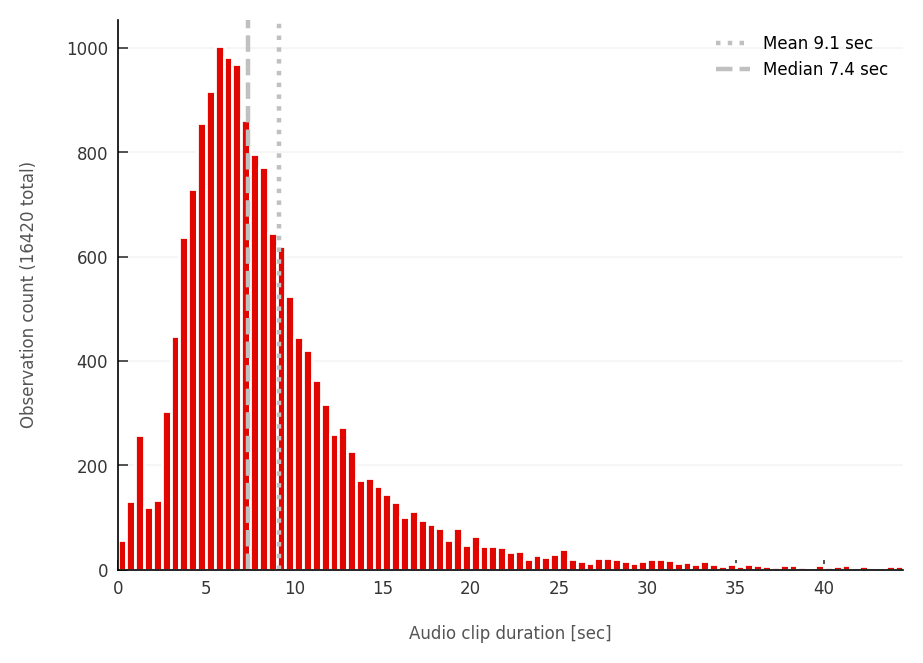

In [41]:
def get_clip_duration(file_path):
    try:
        return librosa.get_duration(path=file_path)
    except:
        return np.nan

if not "clip_duration" in radio_messages.columns:
    radio_messages["clip_duration"] = radio_messages["file_path"].apply(get_clip_duration)
    # radio_messages = radio_messages[radio_messages["clip_duration"] < 30]

plt.hist(
    radio_messages["clip_duration"],
    bins=np.arange(0, 45, 0.5),
    # density=True,
    color=COLORMAP.F1_red,
    edgecolor="white",
    linewidth=1,
)
plt.axvline(
    x=radio_messages["clip_duration"].mean(),
    color="silver",
    linestyle="dotted",
    label=f"Mean {radio_messages["clip_duration"].mean():.1f} sec",
)
plt.axvline(
    x=radio_messages["clip_duration"].median(),
    color="silver",
    linestyle="dashed",
    label=f"Median {radio_messages["clip_duration"].median():.1f} sec",
)
plt.legend(loc="upper right")
plt.xlabel("Audio clip duration [sec]")
# plt.ylabel("Probability density")
plt.ylabel(f"Observation count ({len(radio_messages)} total)")
plt.show()

In [42]:
def download_audiofiles(file_path_todo_list):
    for _, radio_message in tqdm(list(file_path_todo_list), smoothing=0):
        if not Path(radio_message["file_path"]).exists():
            try:
                with open(radio_message["file_path"], mode="wb") as file:
                    file.write(requests.get(radio_message["recording_url"]).content)
            except:
                print("Failed on", radio_message["file_path"])

download_audiofiles(
    file_path_todo_list=radio_messages[~radio_messages["file_path"].apply(Path).apply(Path.exists)][["recording_url", "file_path"]].iloc[::-1].iterrows(),
)

0it [00:00, ?it/s]

---

In [64]:
transcriptions = pd.read_csv("data/transcriptions.tsv", delimiter="\t").astype(dict(
    transcription_timestamp="datetime64[ns, UTC]",
))

with_transcription = pd.merge(
    left=radio_messages.drop(columns=[
        "meeting_key",
        "session_key",
    ]),
    right=transcriptions,
    on="identifier",
    how="left",
).sort_values("transcription_timestamp").drop_duplicates(
    subset="identifier",
    keep="first",
)
with_transcription = with_transcription[~with_transcription["transcription"].isna()]

print(f"Found {len(with_transcription)} transcribed radio messages")
with_transcription.tail(3)

Found 345 transcribed radio messages


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,transcription_timestamp,modeltype,transcription,avg_logprob,text_nbest,no_speech_prob,temperature,compression_ratio,sum_logprob_nbest,token_nbest
11931,55,2024-08-25 13:29:31.123000+00:00,https://livetiming.formula1.com/static/2024/20...,Zandvoort,2024,Race,CARSAI01_55_20240825_152902.mp3,data/radio_messages/CARSAI01_55_20240825_15290...,6.120,2025-12-09 20:58:10.205609+00:00,base.en,and I will turn it up time 6.7 or soft behind ...,-0.738876,['and I will turn it up time 6.7 or soft behin...,0.075914,0.0,0.881356,"[-11.335271835327148, -11.972057342529297, -12...","[[290, 314, 481, 1210, 340, 510, 640, 718, 13,..."
9494,3,2024-05-24 11:49:35.607000+00:00,https://livetiming.formula1.com/static/2024/20...,Monaco,2024,Practice 1,DANRIC01_3_20240524_134906.mp3,data/radio_messages/DANRIC01_3_20240524_134906...,3.816,2025-12-09 20:58:10.205640+00:00,base.en,And you can consider N39 if you need more stab...,-0.310157,['And you can consider N39 if you need more st...,0.158848,0.0,0.912281,"[-4.2039031982421875, -4.239250659942627, -4.0...","[[843, 345, 460, 2074, 399, 2670, 611, 345, 76..."
15517,22,2025-05-23 12:28:49.137000+00:00,https://livetiming.formula1.com/static/2025/20...,Monaco,2025,Practice 1,YUKTSU01_22_20250523_142821.mp3,data/radio_messages/YUKTSU01_22_20250523_14282...,8.328,2025-12-09 20:58:10.580989+00:00,base.en,"Yeah, copy that. It wasn't very nice.",-0.518557,"['Yeah, copy that. That was very nice.', ""Yeah...",0.263107,0.0,0.822222,"[-6.781318187713623, -9.115450859069824, -6.22...","[[9425, 11, 4866, 326, 13, 1320, 373, 845, 362..."


In [71]:
most_recent_label_export = pd.read_json(sorted(Path("label-studio/export").iterdir())[-1]).rename(columns=dict(
    transcription="human_transcription",
))
most_recent_label_export["file_path"] = most_recent_label_export["audio"].str.split("=").str[-1]

with_reference = pd.merge(
    left=with_transcription,
    right=most_recent_label_export[[
        "identifier",
        "human_transcription",
        "lead_time",
        "updated_at",
    ]].rename(columns=dict(updated_at="human_transcription_timestamp")),
    on="identifier",
    how="left",
).sort_values("human_transcription_timestamp").drop_duplicates(
    subset="identifier",
    keep="first",
)

example_list = []
for _, message in with_reference.iterrows():
    preannotation = message["human_transcription"] if type(message["human_transcription"]) is str else "\n" + message["transcription"].lstrip()
    example_list.append(dict(
        data=dict(
            audio=f"""/data/local-files/?d={message["file_path"]}""",
            identifier=message["identifier"],
        ),
        annotations=[dict(
            result=[dict(
                value=dict(
                    text=[message["human_transcription"]],
                ),
                from_name="transcription",
                to_name="audio",
                type="textarea",
                origin="manual",
            )],
            # ground_truth=True,
        )] if type(message["human_transcription"]) is str else [],
        predictions=[dict(
            result=[dict(
                value=dict(
                    text=[message["transcription"]],
                ),
                from_name="transcription",
                to_name="audio",
                type="textarea",
            )],
        )],
        total_annotations=int(type(message["human_transcription"]) is str),
    ))

with open("label-studio/media/upload/annotation_tasks.json", mode="w") as file:
    json.dump(example_list, file)

with_reference = with_reference[~with_reference["human_transcription"].isna()]

print(f"Found {len(with_reference)} transcribed radio messages with reference")
with_reference.sample(3)

Found 345 transcribed radio messages with reference


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,transcription_timestamp,...,avg_logprob,text_nbest,no_speech_prob,temperature,compression_ratio,sum_logprob_nbest,token_nbest,human_transcription,lead_time,human_transcription_timestamp
256,23,2024-03-23 01:52:09.730000+00:00,https://livetiming.formula1.com/static/2024/20...,Melbourne,2024,Practice 3,ALEALB01_23_20240323_015152.mp3,data/radio_messages/ALEALB01_23_20240323_01515...,6.984,2025-12-09 20:57:17.774327+00:00,...,-0.356010,"['Blue 7 position 5.', 'Blue seven position fi...",0.113668,0.0,1.378378,"[-3.548964023590088, -4.2925333976745605, -3.9...","[[4518, 767, 2292, 642, 13], [4518, 3598, 2292...","Urgent: blue 7, position 5.",16.637,2025-12-07 10:56:02.919775+00:00
130,1,2024-06-23 13:42:32.136000+00:00,https://livetiming.formula1.com/static/2024/20...,Barcelona,2024,Race,MAXVER01_1_20240623_154208.mp3,data/radio_messages/MAXVER01_1_20240623_154208...,8.208,2025-12-09 20:56:03.520164+00:00,...,-0.700143,"[""It's always a very, uh, it consists of a cop...",0.165082,0.0,0.919355,"[-12.540383338928223, -11.902426719665527, -16...","[[632, 338, 1464, 257, 845, 11, 21480, 11, 340...",tires are very ... inconsistent. OK. Copy that...,NaN,2025-12-07 10:31:30.933071+00:00
319,10,2025-06-29 13:55:19.223000+00:00,https://livetiming.formula1.com/static/2025/20...,Spielberg,2025,Race,PIEGAS01_10_20250629_155446.mp3,data/radio_messages/PIEGAS01_10_20250629_15544...,8.664,2025-12-09 20:57:52.685016+00:00,...,-0.603435,"[""I have no grip. I'm about to spin every corn...",0.214220,0.0,0.854545,"[-8.448087692260742, -11.539898872375488, -11....","[[314, 423, 645, 11762, 13, 314, 1101, 546, 28...",I have no grip. ***** crazy. I'm about to spi...,11.288,2025-12-07 11:23:41.094200+00:00


In [72]:
with_reference.to_json(
    "data/transcribed_with_reference.json", 
    index=False,
    orient="records",
)

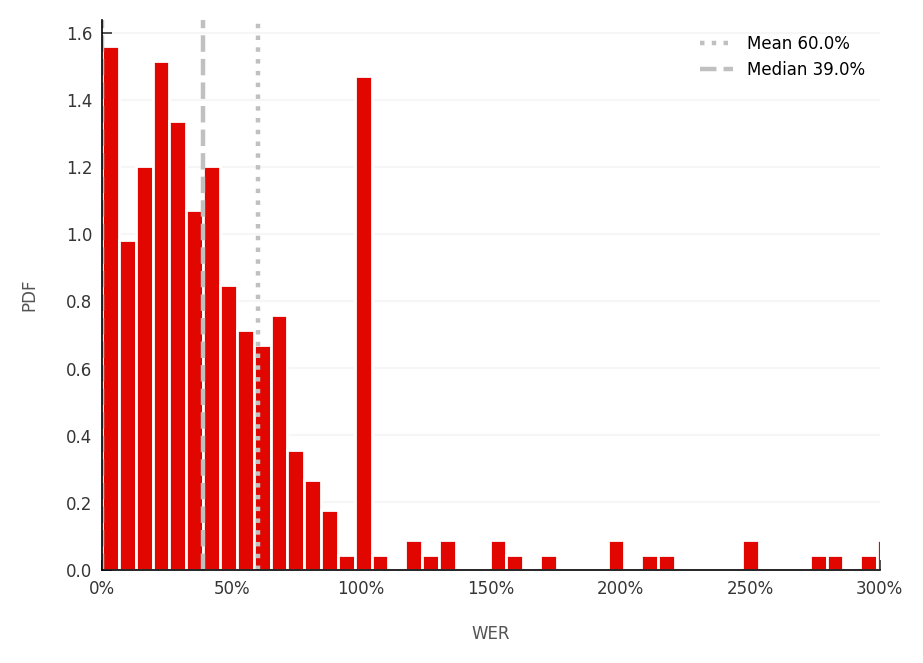

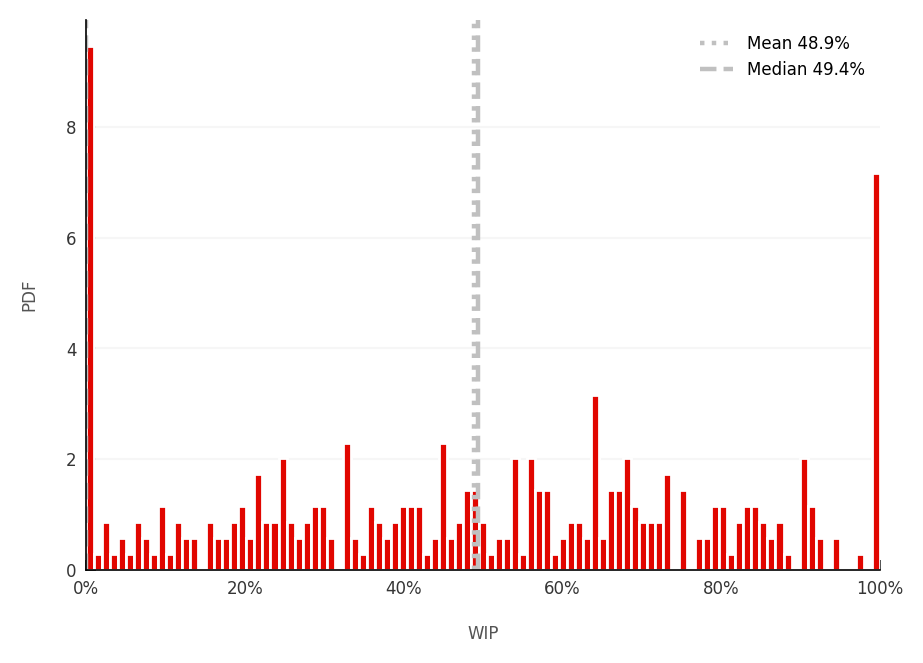

In [73]:
from whisper.normalizers import EnglishTextNormalizer
text_normalizer = EnglishTextNormalizer()

for metric, estimator in [
    ("wer", jiwer.wer),
    ("wip", jiwer.wip),
]:
    with_reference[metric] = with_reference.apply(lambda radio_message: estimator(
        text_normalizer(radio_message["transcription"]),
        text_normalizer(radio_message["human_transcription"]),
    ), axis=1)
    plt.hist(
        with_reference[metric],
        bins=dict(
            wer=200,
            wip=np.linspace(0, 1, 100),
        )[metric],
        density=True,
        color=COLORMAP.F1_red,
        edgecolor="white",
        linewidth=1,
    )
    plt.axvline(
        color="silver",
        linestyle="dashed",
    )
    plt.axvline(
        x=with_reference[metric].mean(),
        color="silver",
        linestyle="dotted",
        label=f"Mean {with_reference[metric].mean():.1%}",
    )
    plt.axvline(
        x=with_reference[metric].median(),
        color="silver",
        linestyle="dashed",
        label=f"Median {with_reference[metric].median():.1%}",
    )
    plt.legend(loc="upper right")
    plt.xlabel(metric.upper())
    plt.ylabel("PDF")
    if metric == "wip":
        plt.xlim(0, 1)
    elif metric == "wer":
        plt.xlim(0, 3)
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.show()

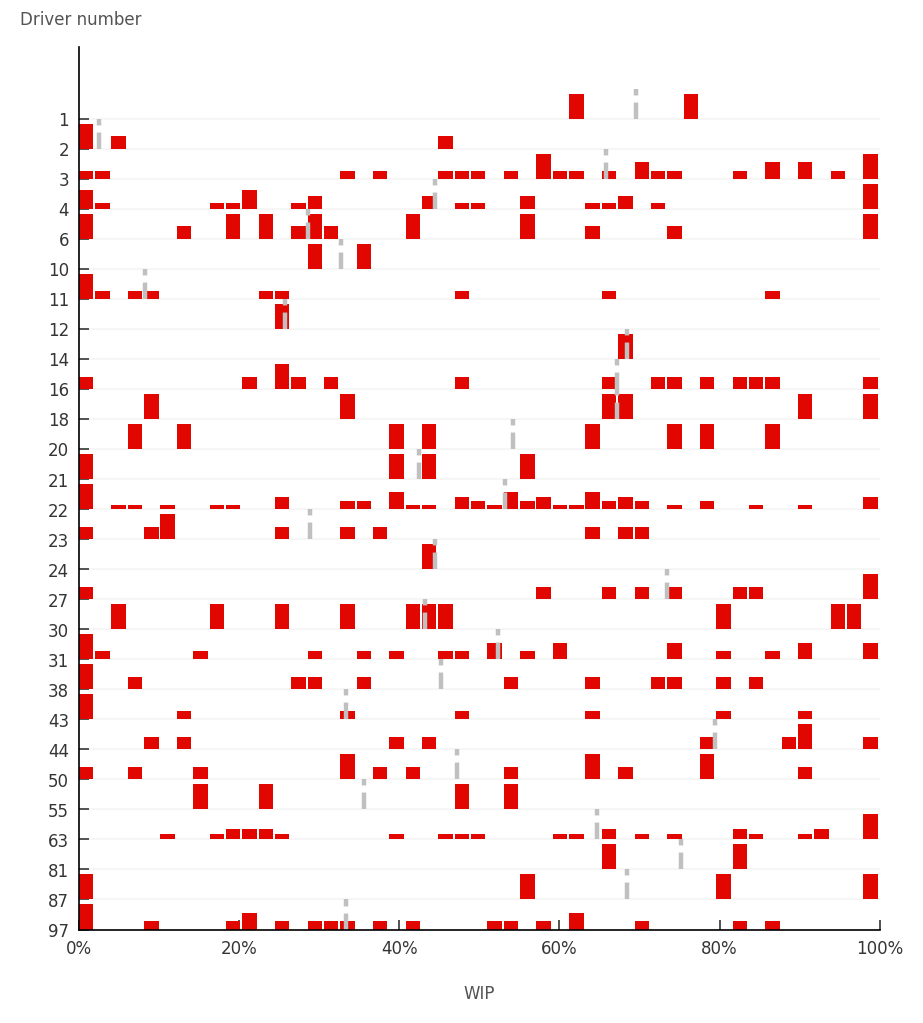

In [74]:
fig, ax = plt.subplots(figsize=(4.5, 5))

for row_idx, (driver_number, driver_data) in enumerate(with_reference.groupby("driver_number")):
    hist, bin_edges = np.histogram(
        driver_data["wip"],
        bins=np.linspace(0, 1, 50),
    )
    plt.bar(
        x=bin_edges[:-1],
        height=np.array(hist) / max(hist) / 1.2,
        bottom=row_idx,
        width=0.018,
        color=COLORMAP.F1_red,
        align="edge",
    )
    plt.vlines(
        x=driver_data["wip"].median(),
        ymin=row_idx,
        ymax=row_idx + 1,
        color="silver",
        linestyle="dashed",
    )

plt.yticks(range(with_reference["driver_number"].nunique()), with_reference["driver_number"].sort_values(ascending=False).unique())
plt.ylabel("Driver number", y=1.02, rotation=0, ha="left")
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xlim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.xlabel("WIP")
plt.show()

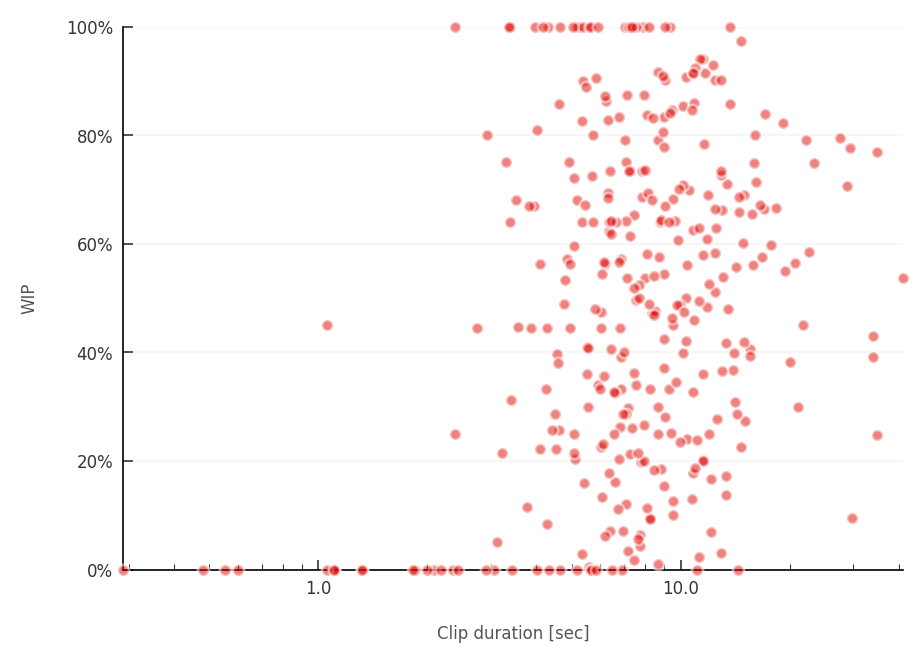

In [75]:
plt.scatter(
    with_reference["clip_duration"],
    with_reference["wip"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ylim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.ylabel("WIP")
plt.show()

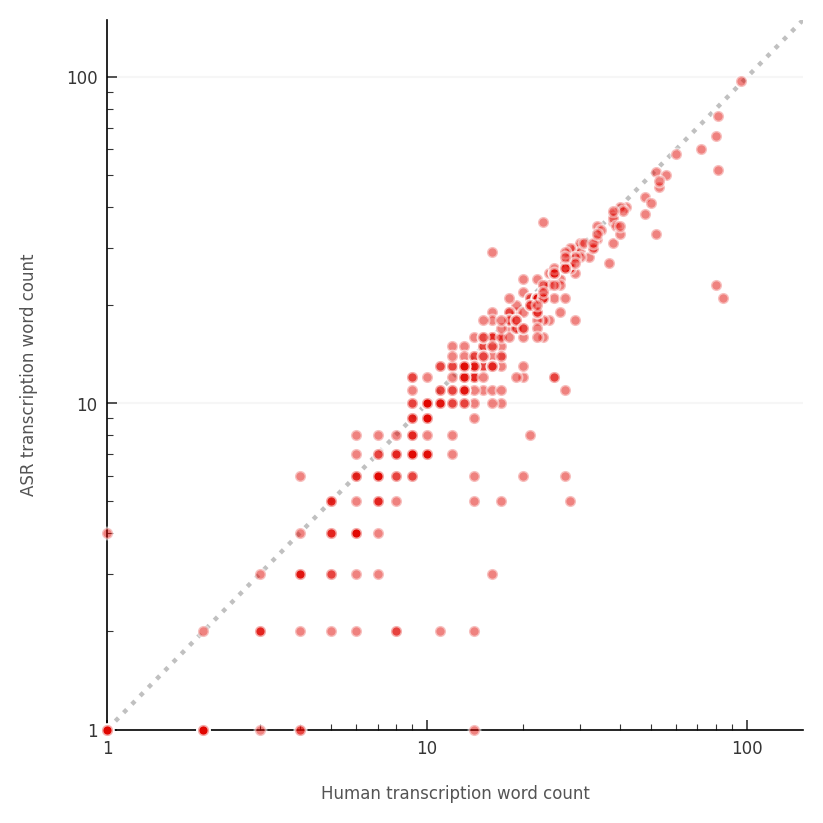

In [76]:
plt.figure(figsize=(4, 4))
plt.scatter(
    with_reference["human_transcription"].str.split(" ").str.len(),
    with_reference["transcription"].str.split(" ").str.len(),
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.plot(
    [0, 1],
    [0, 1],
    transform=plt.gca().transAxes,
    color="silver",
    linestyle="dotted",
    zorder=-1,
)
plt.xscale("log", base=10)
plt.yscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlim(1, 150)
plt.ylim(1, 150)
plt.xlabel("Human transcription word count")
plt.ylabel("ASR transcription word count")
plt.show()

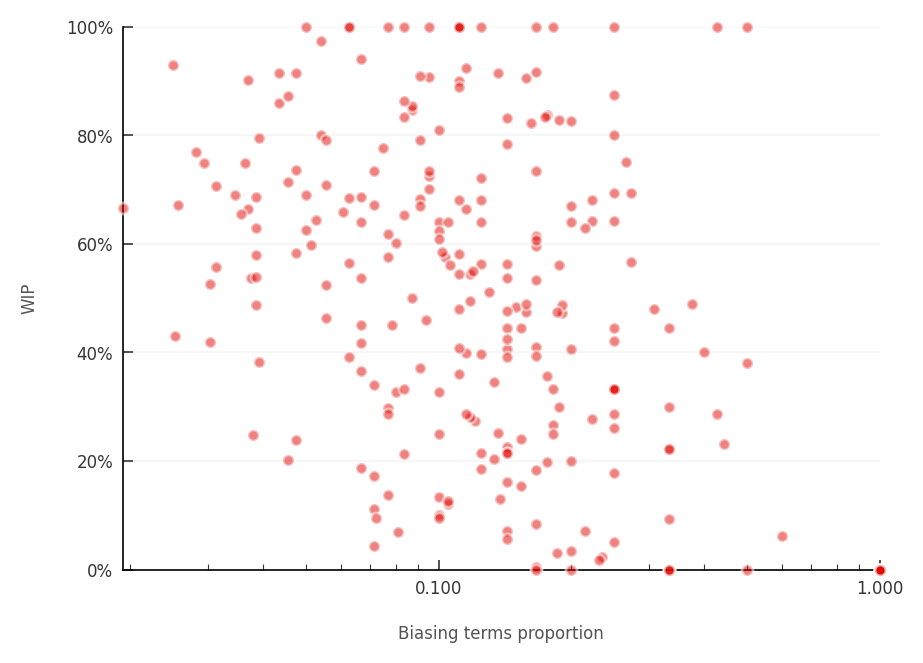

In [61]:
with open("data/biasing_list.txt") as file:
    biasing_terms = [word.strip() for word in file]

def biasing_terms_in_utterance(utterance):
    words = [word.strip(r"\"!#$%&'()*+,./:;<=>?@[\]^_`{|}~") for word in utterance.upper().split()]
    return list(set([word for word in words if word in biasing_terms]))
    
with_reference["biasing_terms"] = with_reference["human_transcription"].apply(biasing_terms_in_utterance)

plt.scatter(
    with_reference["biasing_terms"].apply(len) / with_reference["human_transcription"].str.split().str.len(),
    with_reference["wip"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
# plt.xlim(right=1)
plt.ylim(0, 1)
plt.xlabel("Biasing terms proportion")
plt.ylabel("WIP")
plt.show()

<!-- ln -s radio_messages/ /home/ucloud/.local/share/label-studio/radio_messages -->